In [15]:
%load_ext autoreload
%reload_ext autoreload
%env JAX_PLATFORM_NAME=cpu

import jaxtyping  # noqa: F401

%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: JAX_PLATFORM_NAME=cpu
The jaxtyping extension is already loaded. To reload it, use:
  %reload_ext jaxtyping


In [16]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from jaxtyping import Float, Array

from n3.architecture.controller import StandardController, ControllerLike
from n3.architecture.model import N3, ModelLike
from n3.data import bessel

from n3.utils.utils import grad_norm

### Config

In [17]:
n_samples = 2**15
test_size = 0.2

seed = 0
key = jax.random.PRNGKey(seed)
N_max = 10  # per layer max number of neurons
size_influence = 0.32
epochs = 5_000
print_every = 100

### Dataset

In [18]:
x_train, x_test, y_train, y_test = bessel.generate_data(
    n_samples=n_samples,
    test_size=test_size,
    scaler=MinMaxScaler(feature_range=(-1, 1)),
    seed=seed,
)

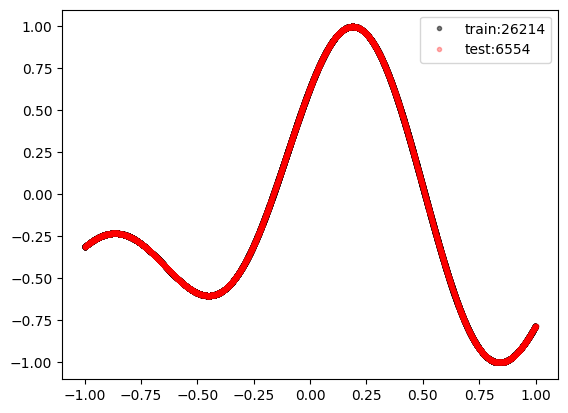

In [19]:
plt.plot(x_train, y_train, "k.", alpha=0.5, label=f"train:{len(x_train)}")
plt.plot(x_test, y_test, "r.", alpha=0.3, label=f"test:{len(x_test)}")
plt.legend()

### Training scheme

In [20]:
def compute_base_loss(
    model: ModelLike,
    control: ControllerLike,
    x: Float[Array, "batch 1"],
    y: Float[Array, "batch 1"],
) -> Float[Array, ""]:
    pred = jax.vmap(model, in_axes=(0, None))(x, control)
    return jnp.mean((pred - y) ** 2)

In [21]:
def compute_size_loss(
    controller: ControllerLike, size_influence: float
) -> Float[Array, ""]:
    N = controller(jnp.ones((1,)))
    return size_influence * jnp.mean((N - 1.0) ** 2)

In [22]:
@eqx.filter_jit
def make_step(
    model: ModelLike,
    controller: ControllerLike,
    size_influence: float,
    x: Float[Array, "batch 1"],
    y: Float[Array, "batch 1"],
    optim: optax.GradientTransformation,
    opt_state: optax.OptState,
) -> tuple[Float[Array, ""], ModelLike, ControllerLike, optax.OptState]:
    loss_base, grads_base = eqx.filter_value_and_grad(compute_base_loss)(
        model, controller, x, y
    )
    loss_size, grads_size = eqx.filter_value_and_grad(compute_size_loss)(
        controller, size_influence
    )
    loss = loss_base + loss_size

    updates, opt_state = optim.update([grads_base, grads_size], opt_state)

    model = eqx.apply_updates(model, updates[0])  # type: ignore
    controller = eqx.apply_updates(controller, updates[1])  # type: ignore
    return loss, model, controller, opt_state

In [23]:
@eqx.filter_jit
def test_step(
    model: ModelLike,
    controller: ControllerLike,
    x: Float[Array, "batch 1"],
    y: Float[Array, "batch 1"],
) -> Float[Array, ""]:
    return compute_base_loss(model, controller, x, y) + compute_size_loss(
        controller, size_influence
    )

In [24]:
model_key, control_key = jax.random.split(key)
n3 = N3(1, 1, [N_max], model_key)
control = StandardController(1, control_key)

optim = optax.adam(learning_rate=1e-3)
opt_state = optim.init(eqx.filter([n3, control], eqx.is_inexact_array))

In [25]:
epoch_list = []
test_losses = []
train_losses = []
controls2 = []
base_grad_norms = []
control_grad_norms = []

for epoch in range(epochs):
    train_loss, n3, control, opt_state = make_step(
        n3, control, size_influence, x_train, y_train, optim, opt_state
    )

    if epoch % print_every == 0:
        epoch_list.append(epoch)
        test_loss = test_step(n3, control, x_test, y_test)

        test_losses.append(test_loss)
        train_losses.append(train_loss)
        controls2.append(control.params.item() ** 2)
        control_grad_norms.append(
            grad_norm(eqx.filter_grad(compute_size_loss)(control, size_influence))
        )
        print(
            f"epoch: {epoch_list[-1]}, train_loss: {train_losses[-1]:.4e}, test_loss: {test_losses[-1]:.4e} control2: {controls2[-1]:.4e}"
        )
        print(f"Control_grad_norm: {control_grad_norms[-1]:.4e}")

epoch: 0, train_loss: 8.0441e-01, test_loss: 8.0985e-01 control2: 9.7511e-07
Control_grad_norm: 6.3937e-01
epoch: 100, train_loss: 6.8929e-01, test_loss: 6.9626e-01 control2: 9.8409e-03
Control_grad_norm: 5.7651e-01
epoch: 200, train_loss: 6.0412e-01, test_loss: 6.1237e-01 control2: 3.7022e-02
Control_grad_norm: 5.1686e-01
epoch: 300, train_loss: 5.3773e-01, test_loss: 5.4757e-01 control2: 7.8614e-02
Control_grad_norm: 4.6056e-01
epoch: 400, train_loss: 5.0133e-01, test_loss: 5.1259e-01 control2: 1.3178e-01
Control_grad_norm: 4.0767e-01
epoch: 500, train_loss: 4.6995e-01, test_loss: 4.8094e-01 control2: 1.9380e-01
Control_grad_norm: 3.5826e-01
epoch: 600, train_loss: 4.4497e-01, test_loss: 4.5574e-01 control2: 2.6206e-01
Control_grad_norm: 3.1237e-01
epoch: 700, train_loss: 4.2314e-01, test_loss: 4.3360e-01 control2: 3.3413e-01
Control_grad_norm: 2.7005e-01
epoch: 800, train_loss: 3.8218e-01, test_loss: 3.9127e-01 control2: 4.0775e-01
Control_grad_norm: 2.3133e-01
epoch: 900, train_los

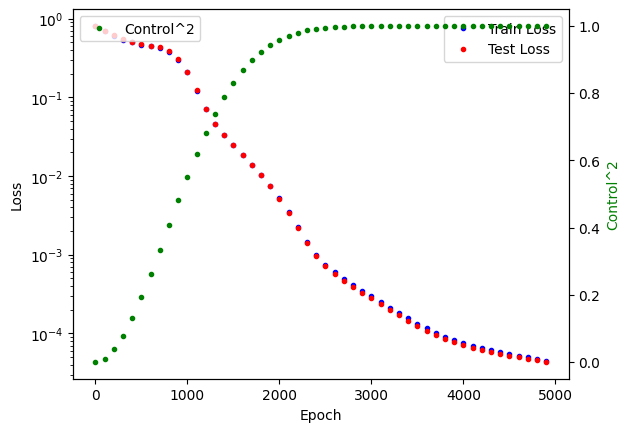

In [26]:
fig, ax1 = plt.subplots()

# Plotting train and test losses
ax1.plot(epoch_list, train_losses, "b.", label="Train Loss")
ax1.plot(epoch_list, test_losses, "r.", label="Test Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color="k")
ax1.set_yscale("log")
# ax1.set_xscale("log")

# Creating a second y-axis to plot control gradient norms
ax2 = ax1.twinx()
ax2.plot(epoch_list, controls2, "g.", label="Control^2")
ax2.set_ylabel("Control^2", color="g")

ax1.legend()
ax2.legend()
plt.show()

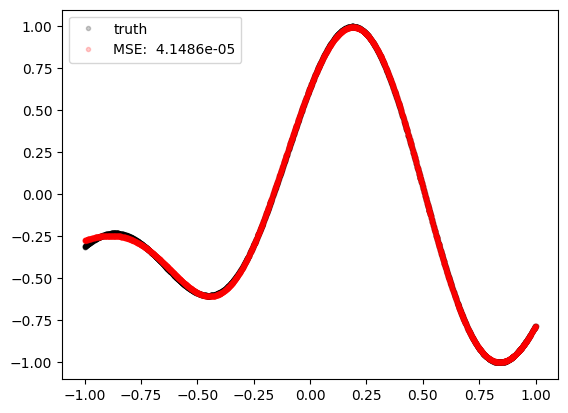

In [27]:
y_pred = jax.vmap(n3, in_axes=(0, None))(x_test, control)
test_loss = jnp.mean((y_pred - y_test) ** 2)

plt.plot(x_test, y_test, "k.", alpha=0.2, label="truth")
plt.plot(x_test, y_pred, "r.", alpha=0.2, label=f"MSE: {test_loss: .4e}")
plt.legend()